In [1]:
%load_ext rpy2.ipython

In [2]:
%%R
install.packages("PMCMRplus", dependencies=TRUE, quiet=TRUE, repos="https://cran.ma.imperial.ac.uk/")
library(PMCMRplus)

R[write to console]: also installing the dependencies ‘classInt’, ‘questionr’, ‘MatrixModels’, ‘conquer’, ‘openxlsx’, ‘RcppEigen’, ‘klaR’, ‘survival’, ‘htmlTable’, ‘cubature’, ‘pbkrtest’, ‘quantreg’, ‘rio’, ‘lme4’, ‘TH.data’, ‘agricolae’, ‘coin’, ‘Hmisc’, ‘km.ci’, ‘metafor’, ‘np’, ‘car’, ‘multcomp’, ‘NSM3’


R[write to console]: Updating HTML index of packages in '.Library'

R[write to console]: Making 'packages.html' ...
R[write to console]:  done



In [34]:
import os
import sys
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from typing import List
#from scipy import stats
from scipy.stats import kruskal
from statsmodels.stats.multitest import multipletests

%matplotlib inline

In [9]:
from cancer_package import constants, preprocessing

In [5]:
USE_ENERGY_PROTEINS = False
NON_NAN_THRESH = .7
REPLACE_BY_NAN = False
N_FOLDS = 10

original dataset shape: (231, 117)
rm 22 proteins with no data
rm 28 energy proteins


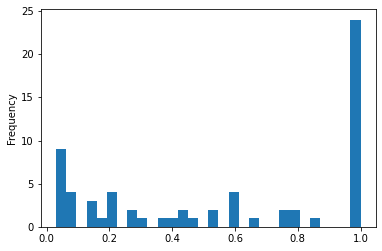

preprocessed dataset shape: (231, 26)
GC           47
LC           33
CTL          33
CCA          25
LD (PM)      23
CRC          22
LD (COPD)    17
BC           17
EC           14
Name: category, dtype: int64


In [31]:
data = pd.read_csv( os.path.join(constants.DATA_DIRECTORY, 'cancer_and_ld_patients.csv'))
protein_group = pd.read_csv( os.path.join(constants.DATA_DIRECTORY, 'protein_group.csv'))

# checking we have data
print(f"original dataset shape: {data.shape}")

data_prep = preprocessing.BasicPreprocessing(data, constants.NA_VALUE, USE_ENERGY_PROTEINS)
data_prep.organise_proteins(protein_group)
data_prep.non_nan_share_hist(bins=30)
data_prep.rm_execess_nans(NON_NAN_THRESH, by_group=False)

if REPLACE_BY_NAN:
    data_prep.replace_nans()
    print("replaced NaNs")

data = data_prep.data
proteins = data_prep.proteins

print(f"preprocessed dataset shape: {data.shape}")
print(data.category.value_counts())

In [ ]:
"""
fig, _ = plt.subplots(1, 1, figsize=(20, 20)) 
sns.heatmap(data[proteins].corr())

fig, _ = plt.subplots(1, 1, figsize=(20, 20)) 
sns.heatmap(data[proteins].corr("spearman"))
"""

In [ ]:
"""
for my_protein in proteins:
  sns.histplot(
      #data=pd.concat([np.log(data[my_protein]), data["category"]], axis=1),
      data=data[[my_protein, "category"]],
      x=my_protein,
      hue="category",
      element="step"
  ) 
  plt.show()
"""

In [32]:
# https://www.statsmodels.org/dev/generated/statsmodels.stats.multitest.multipletests.html

cancer_ctl_data = data[~data.category.str.contains("LD")]

kruskal_p_vals = {my_protein:
  kruskal(
      *[group[my_protein].values 
        for _, group in cancer_ctl_data.groupby("category")]
  ).pvalue
  for my_protein in proteins
}

n_h0_rejections = sum([val < .05 for val in kruskal_p_vals.values()])
print(f"number of rejections of the null according without correction {n_h0_rejections}")

number of rejections of the null according without correction 18


In [46]:
reject_h0_corrected, pvals_corrected, _, _ = multipletests(
    list(kruskal_p_vals.values()),
    method="holm", #"fdr_bh",
    alpha=0.05
)

proteins_kw_test = pd.DataFrame(
    {
        "protein": kruskal_p_vals.keys(),
        "p_val_corrected": pvals_corrected,
        "reject_h0": reject_h0_corrected
    }
)

kw_significant_proteins = proteins_kw_test[proteins_kw_test.reject_h0].protein

print(f"we reject H_0 for {proteins_kw_test.reject_h0.sum()}")
proteins_kw_test.style.format({'p_val_corrected': '{:.3%}'})

we reject H_0 for 8


,protein,p_val_corrected,reject_h0
0,HSP90AA1,7.154%,False
1,HSP90AB1,2.793%,True
2,HSP90B1,5.827%,False
3,TRAP1,0.011%,True
4,FKBP4,0.003%,True
5,HSPA2,36.633%,False
6,HSPA5,82.382%,False
7,HSPA6,28.670%,False
8,HSPA8,82.382%,False
9,HSPA9,0.110%,True


In [36]:
cancer_types = ['LC', 'BC', 'CCA', 'CRC', 'EC', 'GC']
%R -i cancer_ctl_data
%R -i kw_significant_proteins
%R -i cancer_types

In [37]:
%%R

# just to garantee that CTL is always the first group
# since that is what determines it should be used as control group
cancer_types = unlist(cancer_types)
cancer_ctl_data$category <- factor(
    cancer_ctl_data$category,
    ordered = TRUE,
    levels=c('CTL', cancer_types)
)


all_statistics = c()
all_p_values = c()
for (col in kw_significant_proteins) {
    hyp_test = kwManyOneDunnTest(
        cancer_ctl_data[[col]], 
        cancer_ctl_data$category,
        alternative = "two.sided",
        p.adjust.method = "holm"
    )
    print(paste("-----------------------------   ", col, "  ---------------------------"))
    summary(hyp_test)
    hyp_test_statistic = hyp_test$statistic
    colnames(hyp_test_statistic) = col
    all_statistics = cbind(all_statistics, hyp_test_statistic)
    
    hyp_test_p_values = hyp_test$p.value
    colnames(hyp_test_p_values) = col
    all_p_values = cbind(all_p_values, hyp_test_p_values)
}

[1] "-----------------------------    HSP90AB1   ---------------------------"


R[write to console]: 
	Pairwise comparisons using Dunn's many-to-one test


R[write to console]: data: cancer_ctl_data[[col]] and cancer_ctl_data$category

R[write to console]: alternative hypothesis: two.sided

R[write to console]: P value adjustment method: holm

R[write to console]: H0



               z value Pr(>|z|)  
LC - CTL == 0   -2.173  0.11906  
BC - CTL == 0    0.608  1.00000  
CCA - CTL == 0  -0.677  1.00000  
CRC - CTL == 0  -2.735  0.03738 *
EC - CTL == 0    0.576  1.00000  
GC - CTL == 0   -2.681  0.03738 *


R[write to console]: ---

R[write to console]: Signif. codes: 0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1



[1] "-----------------------------    TRAP1   ---------------------------"


R[write to console]: 
	Pairwise comparisons using Dunn's many-to-one test


R[write to console]: data: cancer_ctl_data[[col]] and cancer_ctl_data$category

R[write to console]: alternative hypothesis: two.sided

R[write to console]: P value adjustment method: holm

R[write to console]: H0



               z value  Pr(>|z|)   
LC - CTL == 0    3.554 0.0022789 **
BC - CTL == 0    3.455 0.0027562 **
CCA - CTL == 0   2.766 0.0170201  *
CRC - CTL == 0   1.883 0.1193918   
EC - CTL == 0    3.314 0.0036853 **
GC - CTL == 0    0.034 0.9730440   


R[write to console]: ---

R[write to console]: Signif. codes: 0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1



[1] "-----------------------------    FKBP4   ---------------------------"


R[write to console]: 
	Pairwise comparisons using Dunn's many-to-one test


R[write to console]: data: cancer_ctl_data[[col]] and cancer_ctl_data$category

R[write to console]: alternative hypothesis: two.sided

R[write to console]: P value adjustment method: holm

R[write to console]: H0



               z value   Pr(>|z|)    
LC - CTL == 0   -4.969 4.0367e-06 ***
BC - CTL == 0   -4.146 0.00013554 ***
CCA - CTL == 0  -2.750 0.01190523   *
CRC - CTL == 0  -4.313 8.0471e-05 ***
EC - CTL == 0   -0.838 0.40186549    
GC - CTL == 0   -3.416 0.00190564  **


R[write to console]: ---

R[write to console]: Signif. codes: 0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1



[1] "-----------------------------    HSPA9   ---------------------------"


R[write to console]: 
	Pairwise comparisons using Dunn's many-to-one test


R[write to console]: data: cancer_ctl_data[[col]] and cancer_ctl_data$category

R[write to console]: alternative hypothesis: two.sided

R[write to console]: P value adjustment method: holm

R[write to console]: H0



               z value   Pr(>|z|)    
LC - CTL == 0    4.260 0.00010241 ***
BC - CTL == 0    4.334 8.8009e-05 ***
CCA - CTL == 0   1.931 0.07836323   .
CRC - CTL == 0   2.062 0.07836323   .
EC - CTL == 0    3.122 0.00717592  **
GC - CTL == 0    2.254 0.07268166   .


R[write to console]: ---

R[write to console]: Signif. codes: 0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1



[1] "-----------------------------    HSPB1   ---------------------------"


R[write to console]: 
	Pairwise comparisons using Dunn's many-to-one test


R[write to console]: data: cancer_ctl_data[[col]] and cancer_ctl_data$category

R[write to console]: alternative hypothesis: two.sided

R[write to console]: P value adjustment method: holm

R[write to console]: H0



               z value Pr(>|z|)  
LC - CTL == 0   -1.746 0.404323  
BC - CTL == 0   -0.536 0.592226  
CCA - CTL == 0   2.588 0.057914 .
CRC - CTL == 0  -1.536 0.498641  
EC - CTL == 0   -1.234 0.498641  
GC - CTL == 0   -1.403 0.498641  


R[write to console]: ---

R[write to console]: Signif. codes: 0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1



[1] "-----------------------------    HSPB5   ---------------------------"


R[write to console]: 
	Pairwise comparisons using Dunn's many-to-one test


R[write to console]: data: cancer_ctl_data[[col]] and cancer_ctl_data$category

R[write to console]: alternative hypothesis: two.sided

R[write to console]: P value adjustment method: holm

R[write to console]: H0



               z value Pr(>|z|)  
LC - CTL == 0    0.249 1.000000  
BC - CTL == 0   -0.557 1.000000  
CCA - CTL == 0   2.707 0.040762 *
CRC - CTL == 0  -1.914 0.278163  
EC - CTL == 0   -1.105 1.000000  
GC - CTL == 0    0.756 1.000000  


R[write to console]: ---

R[write to console]: Signif. codes: 0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1



[1] "-----------------------------    CCT1   ---------------------------"


R[write to console]: 
	Pairwise comparisons using Dunn's many-to-one test


R[write to console]: data: cancer_ctl_data[[col]] and cancer_ctl_data$category

R[write to console]: alternative hypothesis: two.sided

R[write to console]: P value adjustment method: holm

R[write to console]: H0



               z value   Pr(>|z|)    
LC - CTL == 0   -3.584 0.00168868  **
BC - CTL == 0   -1.862 0.12523809    
CCA - CTL == 0  -3.894 0.00059166 ***
CRC - CTL == 0  -3.424 0.00246658  **
EC - CTL == 0   -2.800 0.01531298   *
GC - CTL == 0   -1.391 0.16423019    


R[write to console]: ---

R[write to console]: Signif. codes: 0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1



[1] "-----------------------------    CCT5   ---------------------------"


R[write to console]: 
	Pairwise comparisons using Dunn's many-to-one test


R[write to console]: data: cancer_ctl_data[[col]] and cancer_ctl_data$category

R[write to console]: alternative hypothesis: two.sided

R[write to console]: P value adjustment method: holm

R[write to console]: H0



               z value   Pr(>|z|)    
LC - CTL == 0   -4.106 0.00024119 ***
BC - CTL == 0   -2.931 0.01015169   *
CCA - CTL == 0  -3.435 0.00237108  **
CRC - CTL == 0  -3.824 0.00065602 ***
EC - CTL == 0   -2.259 0.04774748   *
GC - CTL == 0   -1.237 0.21620355    


R[write to console]: ---

R[write to console]: Signif. codes: 0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1



In [ ]:
%R -o all_statistics
%R -o all_p_values

In [ ]:
all_statistics = pd.DataFrame.from_records( all_statistics, columns=list(kw_significant_proteins))
all_statistics.columns = pd.MultiIndex.from_product([all_statistics.columns, ["stat"]])

all_p_values = pd.DataFrame.from_records( all_p_values, columns=list(kw_significant_proteins))
all_p_values.columns = pd.MultiIndex.from_product([all_p_values.columns, ["p-value"]])

In [ ]:
post_hoc = pd.concat([all_p_values, all_statistics], axis=1)
post_hoc = post_hoc.sort_index(axis=1,level=[0,1],ascending=[True,False])
post_hoc["category"] = cancer_types
post_hoc.set_index("category", inplace=True)
post_hoc

In [ ]:
from matplotlib import colors
import seaborn as sns

def b_g(s):
    cm=sns.light_palette((260, 75, 60), input="husl", as_cmap=True, reverse=True)
    norm = colors.Normalize(0,.025)
    normed = norm(abs(s.values))
    c = [colors.rgb2hex(x) for x in plt.cm.get_cmap(cm)(normed)]
    return ['background-color: %s' % color for color in c]

post_hoc.style.apply(b_g, subset=all_p_values.columns)